<a href="https://colab.research.google.com/github/victor-wildlife/wild_about_ai_classifications/blob/main/wild_about_ai_classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title <font size="5">↓ ឵឵<i>Load libraries</font> { vertical-output: true }

import base64, io
import os
import gdown
import json
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt


from IPython.display import HTML
from IPython.display import HTML, display, clear_output


In [2]:
# @title <font size="5">↓ ឵឵<i>Download latest zooniverse classifications</font> { vertical-output: true }

url = "https://drive.google.com/drive/folders/12GAX8TZegfS1_Q8bbp4IZEJJ_Mj_FVG0"
gdown.download_folder(url, quiet=True, use_cookies=False)


['/content/zooniverse_classifications/spyfish-aotearoa-classifications.csv',
 '/content/zooniverse_classifications/spyfish-aotearoa-subjects.csv',
 '/content/zooniverse_classifications/spyfish-aotearoa-workflows.csv']

In [3]:
# @title <font size="5">↓ ឵឵<i>Read zooniverse classifications as df</font> { vertical-output: true }

directory = os.path.join(os.getcwd(),'zooniverse_classifications')

for file in os.listdir(directory):
  
  file_path = os.path.join(directory, file)
  
  if "workflows" in file:
    workflows_df = pd.read_csv(file_path)
  
  if "classifications" in file:
    classifications_df = pd.read_csv(file_path)
  
  if "subjects" in file:
    subjects_df = pd.read_csv(file_path)


In [4]:
# @title <font size="5">↓ ឵឵<i>Get subject information</font> { vertical-output: true }

# Function to extract metadata from subjects
def extract_metadata(subj_df: pd.DataFrame):
    """
    > The function takes a dataframe with a column called `metadata` that contains a JSON string. It
    then flattens the JSON string into a dataframe and returns the original dataframe with the
    `metadata` column removed and the flattened dataframe
    :param subj_df: The dataframe containing the subject data
    :return: A tuple of two dataframes.
    """

    # Reset index of df
    subj_df = subj_df.reset_index(drop=True).reset_index()

    # Flatten the metadata information
    meta_df = pd.json_normalize(subj_df.metadata.apply(json.loads))

    # Drop metadata and index columns from original df
    subj_df = subj_df.drop(
        columns=[
            "metadata",
            "index",
        ]
    )

    return subj_df, meta_df
    
    
# Extract metadata from uploaded subjects
subjects_orig, subjects_meta = extract_metadata(subjects_df)

# Combine metadata info with the subjects df and drop duplicates
subjects = pd.concat([subjects_orig, subjects_meta], axis=1).drop_duplicates(
            ["subject_id"], keep="last"
        )


In [8]:
# @title <font size="5">↓ ឵឵<i>Select username</font> { vertical-output: true }
    
# Create a text input widget for the username
username_widget = widgets.Text(
    value='',
    placeholder='Enter your Zooniverse username(s), separated by commas',
    description='Username(s):',
    disabled=False
)

# Create a button to filter the dataframe
check_classifications_button = widgets.Button(
    description='Check username(s)'
    )

# Display the widgets
display(username_widget)
display(check_classifications_button)

out = widgets.Output()
display(out)

# Define a function to process the dataframe by username
def check_user_classifications(button):
    with out:
        clear_output()
        # Split the string of usernames based on commas.
        list_of_strings = username_widget.value.split(', ')

        # Convert each string in the list to a list item.
        list_of_usernames = [item for item in list_of_strings]
        
        if set(list_of_usernames).intersection(classifications_df.user_name.unique()) != set():
          filtered_classifications = classifications_df[classifications_df['user_name'].isin(list_of_usernames)]
          print("You have selected", filtered_classifications.shape[0], "classifications from", list_of_usernames)
        
        else:
          raise ValueError(
                    "The username(s) doesn't exist or doesn't have classifications any subjects in this project"
                )
      
      
check_classifications_button.on_click(check_user_classifications)

Text(value='', description='Username(s):', placeholder='Enter your Zooniverse username(s), separated by commas…

Button(description='Check username(s)', style=ButtonStyle())

Output()

In [12]:
# @title <font size="5">↓ ឵឵<i>Define functions to filter and process classifications</font> { vertical-output: true }

def flatten_clip_annotations(annotations, row_class_id, rows_list: list):
    """
    For each annotation, if the task is T0, then for each species annotated, flatten the relevant
    answers and save the species of choice, class and subject id.
    :param annotations: the list of annotations for a given subject
    :param row_class_id: the classification id
    :param rows_list: a list of dictionaries, each dictionary is a row in the output dataframe
    :return: A list of dictionaries, each dictionary containing the classification id, the label, the
    first seen time and the number of individuals.
    """

    for ann_i in annotations:
        if ann_i["task"] == "T0":
            # Select each species annotated and flatten the relevant answers
            for value_i in ann_i["value"]:
                choice_i = {}
                # If choice = 'nothing here', set follow-up answers to blank
                if value_i["choice"] == "NOTHINGHERE":
                    f_time = ""
                    inds = ""
                # If choice = species, flatten follow-up answers
                else:
                    answers = value_i["answers"]
                    for k in answers.keys():
                        if "EARLIESTPOINT" in k:
                            f_time = answers[k].replace("S", "")
                        if "HOWMANY" in k:
                            inds = answers[k]
                            # Deal with +20 fish options
                            if inds == "2030":
                                inds = "25"
                            if inds == "3040":
                                inds = "35"
                        elif "EARLIESTPOINT" not in k and "HOWMANY" not in k:
                            f_time, inds = None, None

                # Save the species of choice, class and subject id
                choice_i.update(
                    {
                        "classification_id": row_class_id,
                        "label": value_i["choice"],
                        "first_seen": f_time,
                        "how_many": inds,
                    }
                )

                rows_list.append(choice_i)

    return rows_list
    
def process_clips(df: pd.DataFrame):
    """
    This function takes a dataframe of classifications and returns a dataframe of annotations
    :param df: the dataframe of classifications
    :type df: pd.DataFrame
    :return: A dataframe with the classification_id, label, how_many, first_seen, https_location,
    subject_type, and subject_ids.
    """

    # Create an empty list
    rows_list = []

    # Loop through each classification submitted by the users
    for index, row in df.iterrows():
        # Load annotations as json format
        annotations = json.loads(row["annotations"])

        rows_list = flatten_clip_annotations(
            annotations, row["classification_id"], rows_list
        )
        

    # Create a data frame with annotations as rows
    annot_df = pd.DataFrame(
        rows_list, 
        columns=["classification_id", "label", "first_seen", "how_many"]
    )

    # Specify the type of columns of the df
    annot_df["how_many"] = pd.to_numeric(annot_df["how_many"])
    annot_df["first_seen"] = pd.to_numeric(annot_df["first_seen"])

    # Add subject id to each annotation
    annot_df = pd.merge(
        annot_df,
        df.drop(columns=["annotations"]),
        how="left",
        on="classification_id",
    )

    # Select only relevant columns
    annot_df = annot_df[
        [
            "classification_id",
            "label",
            "how_many",
            "first_seen",
            "subject_ids",
            "Subject_type",
            "upl_seconds",
            "ProtectionStatus",
            "!LinkToMarineReserve",
            "#created_on",
        ]
    ]

    return pd.DataFrame(annot_df)
    
# Define a function to process the classifications
def process_classifications(df, subjects):
    # Combine the filtered classifications and subject information
    annotations_df = pd.merge(
        df,
        subjects,
        how="left",
        left_on="subject_ids",
        right_on="subject_id",
        validate="many_to_one",
    )

    # Select only "clip" classifications
    annotations_df = annotations_df[annotations_df['Subject_type'] == "clip"]

    # Flatten the classifications
    flattened_df = process_clips(annotations_df)

    # Recode nothing here annotations
    flattened_df.loc[flattened_df['label'] == 'NOTHINGHERE', 'how_many'] = 1

    # Recode values that contain the string "Type I MPA (Marine Reserve)" to "Protected"
    flattened_df['ProtectionStatus'] = flattened_df['ProtectionStatus'].replace('Type I MPA (Marine Reserve)', 'Protected')
    flattened_df['ProtectionStatus'] = flattened_df['ProtectionStatus'].replace('No Protection', 'No Protected')

    # Sample an equal number of classifications inside and outside the reserves
    groups = flattened_df.groupby('ProtectionStatus')
    flattened_df = groups.apply(lambda x: x.sample(groups.size().min())).reset_index(drop=True)

    return flattened_df

# Define function to plot the classifications
def plot_side_side_classifications(data, user_i):
    # Group data by species and protection status and sum counts
    species_counts = data.groupby(['label', 'ProtectionStatus'])['how_many'].sum().unstack()
    
    # Arrange df to have protected vs no protected and from higest to lowest number of count
    species_counts = species_counts.sort_values("Protected", ascending=False)[['Protected', 'No Protected']]

    # Plot side-by-side bar chart
    ax = species_counts.plot(kind='bar', width=0.4)
    plt.xlabel('Species')
    plt.ylabel('Count')
    plt.title(f'Count of species of {data.classification_id.nunique()} classifications by {user_i}')
    plt.legend(title='Protection', loc='upper right')
    plt.show()



# Define functions to download df as CSV
def create_download_link_csv(df, title = "Download CSV file", filename = "data.csv"):  
    # generate in-memory CSV, then base64-encode it
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    
    return HTML(html)

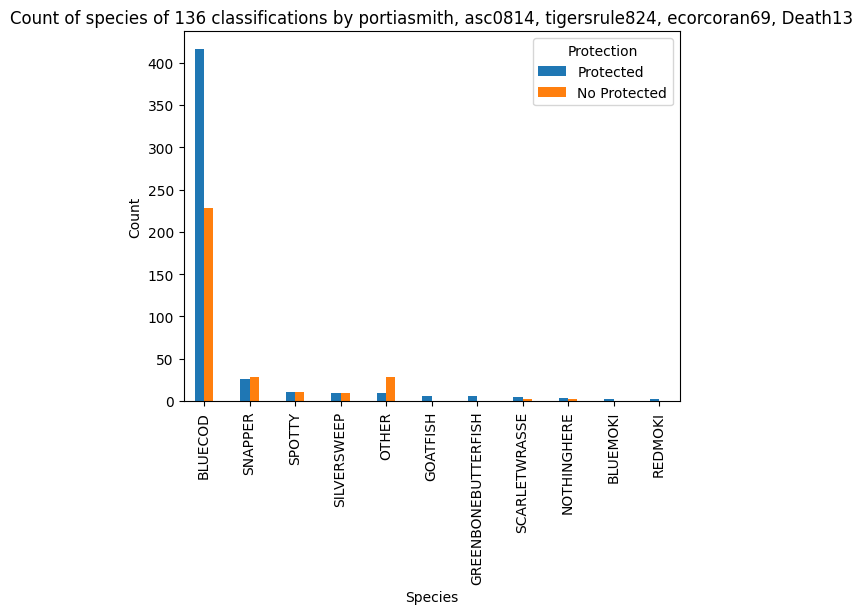

In [16]:
# @title <font size="5">↓ ឵឵<i>Process and download classifications</font> { vertical-output: true }

user_i = username_widget.value

# Split the string of usernames based on commas.
list_of_strings = username_widget.value.split(', ')

# Convert each string in the list to a list item.
list_of_usernames = [item for item in list_of_strings]

# Select classifications provided by the usernames of interest
filtered_classifications = classifications_df[classifications_df['user_name'].isin(list_of_usernames)]
          
# Process and clean the filtered classifications
proccessed_classifications = process_classifications(filtered_classifications, subjects)


plot_side_side_classifications(proccessed_classifications, user_i)

# Provide options to download the classifications as csv
create_download_link_csv(proccessed_classifications,
                          "Download my data in csv",
                          "classifications.csv")